# Understanding Embeddings for RAG Systems

In the first notebook, we explored how Large Language Models work and the basics of RAG (Retrieval Augmented Generation). We learned that RAG systems enhance LLM responses by retrieving relevant context from our own data before generating answers. 
Still there is 1 open question: how to decide which data to retrieve to send for the language model in a Rag Application?
Now, we'll go into the core component that makes RAG possible: embeddings. We'll learn how to convert text into numerical vectors that computers can compare for deciding which to send to the language model.


Open [this image](rag_architecture_workshop.png) for an overview of rag concepts.


# Converting language to numbers


Embeddings are numerical representations of text that capture semantic meaning. They convert words or sentences into vectors (lists of numbers) that can be compared mathematically.

- Similar texts should have similar vector representations
- The dimensionality and quality of embeddings affects performance
- Different embedding models are trained on different data


Embeddings transform text into numbers through several steps:

1. **Tokenization**: Breaking text into smaller pieces
   - Words: "hello world" → ["hello", "world"]
   - Subwords: "playing" → ["play", "##ing"]
   - Characters: For languages like Chinese

2. **Token IDs**: Each token gets mapped to a number
   - Example: "hello" → 15234
   - These mappings are stored in the model's vocabulary

3. **Neural Network Processing**:
   - Tokens pass through multiple transformer layers
   - Each layer learns different aspects (syntax, semantics, context)
   - Final layer outputs the embedding vector

4. **Vector Space**: The final embedding places similar meanings close together
   - Each dimension captures different semantic features
   - Typical sizes: 384, 768, or 1024 dimensions


For this workshop we will be using sentences-tranformers, a popular open-soruce library for working with text embeddings.

In [1]:
from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer
import numpy as np

# 1. Tokenization
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
text = "I love machine learning"
tokens = tokenizer.tokenize(text)
token_ids = tokenizer.encode(text)

print("Original text:", text)
print("Tokens:", tokens)
print("Token IDs:", token_ids)

# 2. Getting Embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
embedding = model.encode(text)

print("\nEmbedding shape:", embedding.shape)
print("First 5 dimensions:", embedding[:5])
# the output can take some seconds to appear

/Users/jean.machado@getyourguide.com/prj/rag-workshop/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Original text: I love machine learning
Tokens: ['i', 'love', 'machine', 'learning']
Token IDs: [101, 1045, 2293, 3698, 4083, 102]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



Embedding shape: (384,)
First 5 dimensions: [-0.04363637 -0.05905439  0.08201234 -0.01076717  0.06119593]


## 2. Understanding Embedding Dimensions

Each dimension in an embedding vector captures different semantic features:
- Word types (noun, verb, etc.)
- Topics (technology, nature, etc.)
- Sentiment (positive, negative)
- And many other abstract features

The more dimensions, the more nuanced the representation, but also:
- More computational cost
- More storage needed
- Risk of overfitting

In [9]:
import time

def time_it(func, runs=3):
    """Time a function over multiple runs"""
    times = []
    for _ in range(runs):
        start = time.time()
        func()
        times.append(time.time() - start)
    return f"{(sum(times) / runs) * 1000:.2f}ms"

small_model = SentenceTransformer('all-MiniLM-L6-v2')  # 384 dims
large_model = SentenceTransformer('all-mpnet-base-v2')  # 768 dims

text = "This is a test sentence"
small_emb = small_model.encode(text)
large_emb = large_model.encode(text)

print(f"Small model dimensions: {small_emb.shape}")
print(f"Large model dimensions: {large_emb.shape}")
print(f"Small model speed: {time_it(lambda: small_model.encode(text))}")
print(f"Large model speed: {time_it(lambda: large_model.encode(text))}")

Small model dimensions: (384,)
Large model dimensions: (768,)
Small model speed: 7.45ms
Large model speed: 11.57ms


#### Let's see how embeddings group similar concepts



Similarity Scores (closer to 1 = more similar):
pizza-burger: 0.460
coffee-tea: 0.616
pizza-coffee: 0.458


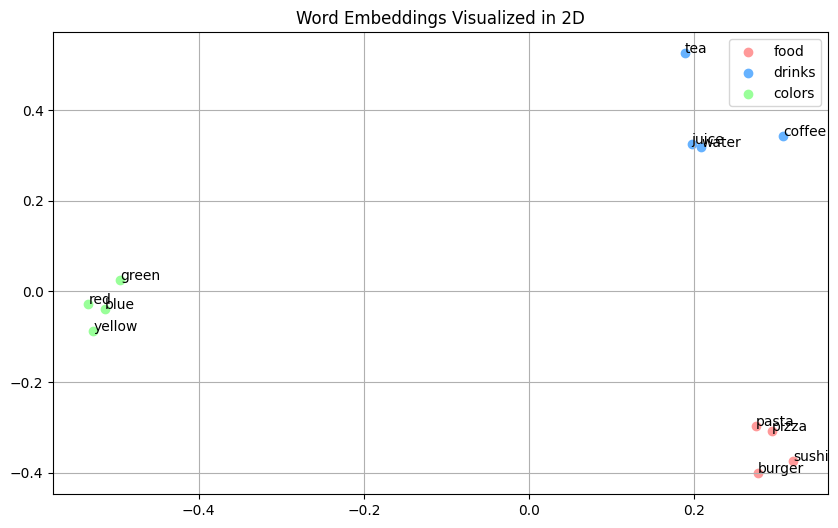

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Create word groups with clear relationships
words = {
    'food': ['pizza', 'burger', 'pasta', 'sushi'],
    'drinks': ['coffee', 'tea', 'juice', 'water'],
    'colors': ['red', 'blue', 'green', 'yellow']
}

# Get embeddings for all words
all_words = [word for group in words.values() for word in group]
embeddings = model.encode(all_words)

# Reduce to 2D for visualization
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Plot with different colors for each group
plt.figure(figsize=(10, 6))
colors = ['#FF9999', '#66B2FF', '#99FF99']
for (group_name, group_words), color in zip(words.items(), colors):
    start_idx = all_words.index(group_words[0])
    x = embeddings_2d[start_idx:start_idx+4, 0]
    y = embeddings_2d[start_idx:start_idx+4, 1]
    plt.scatter(x, y, c=color, label=group_name)
    
    # Add word labels
    for i, word in enumerate(group_words):
        plt.annotate(word, (x[i], y[i]))

def cosine_similarity(v1, v2):
    """ cosine similarity is a measure of similarity between two vectors the higher the value the more similar the vectors are """
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))


# Show some similarity scores
print("\nSimilarity Scores (closer to 1 = more similar):")
print(f"pizza-burger: {cosine_similarity(model.encode('pizza'), model.encode('burger')):.3f}")
print(f"coffee-tea: {cosine_similarity(model.encode('coffee'), model.encode('tea')):.3f}")
print(f"pizza-coffee: {cosine_similarity(model.encode('pizza'), model.encode('coffee')):.3f}")

plt.title("Word Embeddings Visualized in 2D")
plt.legend()
plt.grid(True)
plt.show()


## 3. Multi-language models

You can find different models in english, and all major languages; sometimes they also support more than 1 language.
If you are building an application in a language other than english, consider using a language specific model as they usually perform better for the following reasons:

1. **Vocabulary Coverage**: 
   - Better handling of language-specific words
   - Proper subword tokenization for morphologically rich languages

2. **Cultural Context**:
   - Understanding idioms and expressions
   - Proper handling of formal/informal speech

3. **Syntactic Structure**:
   - Word order differences
   - Grammar patterns

This is why we use different models in our code:

## 4. Other practical advice for using embeddings

1. **Choosing Model Size**:
   - Smaller models (384 dims): Faster, good for simple tasks
   - Larger models (768+ dims): Better quality, slower

2. **Preprocessing**:
   - Clean text (remove noise)
   - Consistent casing
   - Handle special characters

3. **Storage Considerations**:
   - 384 dimensions × 4 bytes = ~1.5KB per embedding
   - Plan database capacity accordingly

Lets now compare an english and a german model.


In [2]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Load different embedding models
english_model = SentenceTransformer('all-MiniLM-L6-v2')  # English-focused
german_model = SentenceTransformer("jinaai/jina-embeddings-v3", trust_remote_code=True) # Multi-Lingual

A new version of the following files was downloaded from https://huggingface.co/jinaai/jina-embeddings-v3:
- custom_st.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- configuration_xlm_roberta.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- rotary.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- mha.py
. Make sure t

## Example 1: Comparing Similar Sentences

Let's see how embeddings capture similarity between sentences in different languages:

In [5]:
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

def compare_sentences(model, sent1, sent2):
    emb1 = model.encode(sent1)
    emb2 = model.encode(sent2)
    return cosine_similarity(emb1, emb2)

# Test pairs in different languages
english_pairs = [
    ("I love Berlin", "Berlin is my favorite city"),
    ("I love Berlin", "I hate vegetables")
]

german_pairs = [
    ("Ich liebe Berlin", "Berlin ist meine Lieblingsstadt"),
    ("Ich liebe Berlin", "Ich hasse Gemüse")
]

print("\nEnglish Model Results:")
for sent1, sent2 in english_pairs:
    sim = compare_sentences(english_model, sent1, sent2)
    print(f"{sent1} <-> {sent2}: {sim:.3f}")

print("\nGerman-English Model Results:")
for sent1, sent2 in german_pairs:
    sim = compare_sentences(german_model, sent1, sent2)
    print(f"{sent1} <-> {sent2}: {sim:.3f}")


English Model Results:
I love Berlin <-> Berlin is my favorite city: 0.904
I love Berlin <-> I hate vegetables: 0.076

German-English Model Results:
Ich liebe Berlin <-> Berlin ist meine Lieblingsstadt: 0.946
Ich liebe Berlin <-> Ich hasse Gemüse: 0.404


## Example 2: Cross-lingual Capabilities

Let's compare how different models handle cross-lingual similarity:

In [14]:
cross_lingual_pairs = [
    ("The weather is nice today", "Das Wetter ist heute schön"),
    ("I need a coffee", "Ich brauche einen Kaffee"),
    ("Berlin is the capital of Germany", "Berlin ist die Hauptstadt von Deutschland")
]

print("Cross-lingual similarity:")
print("\nEnglish-only model:")
for en, de in cross_lingual_pairs:
    sim = compare_sentences(english_model, en, de)
    print(f"{en} <-> {de}: {sim:.3f}")

print("\nGerman-English model:")
for en, de in cross_lingual_pairs:
    sim = compare_sentences(german_model, en, de)
    print(f"{en} <-> {de}: {sim:.3f}")

Cross-lingual similarity:

English-only model:
The weather is nice today <-> Das Wetter ist heute schön: 0.084
I need a coffee <-> Ich brauche einen Kaffee: 0.299
Berlin is the capital of Germany <-> Berlin ist die Hauptstadt von Deutschland: 0.680

German-English model:
The weather is nice today <-> Das Wetter ist heute schön: 0.869
I need a coffee <-> Ich brauche einen Kaffee: 0.944
Berlin is the capital of Germany <-> Berlin ist die Hauptstadt von Deutschland: 0.867


## Example 3: Domain-Specific Comparisons

Let's see how models handle domain-specific terminology:

In [15]:
tourism_pairs = [
    ("Guided tour of the Brandenburg Gate", "Führung durch das Brandenburger Tor"),
    ("Skip the line tickets for museums", "Eintrittskarten ohne Anstehen für Museen"),
    ("Best restaurants in Berlin", "Beste Restaurants in Berlin")
]

print("Tourism domain comparisons:")
for en, de in tourism_pairs:
    en_sim = compare_sentences(english_model, en, de)
    de_sim = compare_sentences(german_model, en, de)
    print(f"\nPair: {en} <-> {de}")
    print(f"English model similarity: {en_sim:.3f}")
    print(f"German-English model similarity: {de_sim:.3f}")

Tourism domain comparisons:

Pair: Guided tour of the Brandenburg Gate <-> Führung durch das Brandenburger Tor
English model similarity: 0.470
German-English model similarity: 0.824

Pair: Skip the line tickets for museums <-> Eintrittskarten ohne Anstehen für Museen
English model similarity: 0.196
German-English model similarity: 0.818

Pair: Best restaurants in Berlin <-> Beste Restaurants in Berlin
English model similarity: 0.941
German-English model similarity: 0.938


## Key Takeaways

1. **Language Support**: Models trained on specific languages perform better for those languages
2. **Cross-lingual Capabilities**: Specialized multilingual models handle cross-language comparisons better
3. **Domain Relevance**: Consider your use case when choosing an embedding model

When building a RAG system:
- Choose embedding models that match your content languages
- Consider using specialized models for specific domains
- Test different models with your actual use cases (And evaluate those)
- Balance performance vs computational cost


# Your turn to play with Embedding Models!

## Concrete Example: Building a Smart Support System

In [6]:
model = SentenceTransformer('all-MiniLM-L6-v2')

def find_most_similar(query, message_list, model, top_k=1):
    """
    Find the most similar customer messages
    Returns: List of (message, score) tuples
    """
    query_embedding = model.encode(query)
    message_embeddings = model.encode(message_list)
    
    # Calculate similarities
    similarities = [
        cosine_similarity(query_embedding, msg_emb) 
        for msg_emb in message_embeddings
    ]
    
    # Get top-k matches
    top_indices = np.argsort(similarities)[-top_k:][::-1]
    return [(message_list[i], similarities[i]) for i in top_indices]

support_messages = {
    'account': [
        "How do I reset my password?",
        "I can't log into my account",
        "How do I change my email?",
        "My account is locked"
    ],
    'shipping': [
        "Where's my order?",
        "Do you ship internationally?",
        "How do I track my package?",
        "Can I change my shipping address?"
    ],
    'billing': [
        "How do I update my payment method?",
        "Can I get a refund?",
        "When will I be charged?",
        "How do I cancel my subscription?"
    ]
}

test_queries = [
    "forgot password",
    "package not here yet",
    "want my money back"
]

print("Basic similarity search:")
for query in test_queries:
    matches = find_most_similar(query, [msg for msgs in support_messages.values() for msg in msgs], model, top_k=2)
    print(f"\nQuery: '{query}'")
    for match, score in matches:
        print(f"Match: '{match}' (Score: {score:.3f})")


Basic similarity search:

Query: 'forgot password'
Match: 'How do I reset my password?' (Score: 0.779)
Match: 'My account is locked' (Score: 0.609)

Query: 'package not here yet'
Match: 'How do I track my package?' (Score: 0.417)
Match: 'Where's my order?' (Score: 0.414)

Query: 'want my money back'
Match: 'Can I get a refund?' (Score: 0.610)
Match: 'How do I cancel my subscription?' (Score: 0.334)


# Task 1
Try these experiments like the example above


In [18]:
# 1. Category Classification
def classify_message(query, categories=support_messages):
    """
    Your turn! Implement a function that:
    1. Takes a customer query
    2. Returns the most likely category (account/shipping/billing)
    Hint: Compare query with all messages in each category
    """
    pass

# 2. Threshold Testing
def is_relevant_query(query, threshold=0.5):
    """
    Your turn! Implement a function that:
    1. Checks if a query is relevant to our support topics
    2. Returns True if similarity is above threshold
    Try with queries like "What's the weather?" vs "Reset password"
    """
    pass

# 4. Bonus: Multi-Language Support
# Try adding some non-English support messages and queries!
# Does the model handle them well?



# Chunking

## Why Do We Need Chunking?

In the previous notebook, we saw how RAG systems use external information to make LLMs smarter. But there's a catch - we might not want to just feed entire documents into our system. We may want to break them into smaller, manageable pieces (chunks) because:

1. **Context Window Limits**: LLMs have a maximum amount of text they can process at once
2. **Relevant Information**: Smaller chunks help us find and retrieve only the most relevant parts of a document
3. **Better Matching**: It's easier to match a question with a small, focused chunk than an entire document

For example, if someone asks "What is RAG?" we want to find and use just the RAG-related chunk, not the entire document about AI concepts.

## Chunking Strategies

We'll explore two main ways to break up text:
1. Simple character-based chunking (split every X characters)
2. Smarter paragraph-based chunking (respect natural text boundaries)

Let's see how these work in practice...

In [19]:
# First, let's load our data
with open('../data/data_example.md', 'r') as f:
    text = f.read()

text[:500]

'Topics\nWhat Are Large Language Models (LLMs)?\nLarge Language Models (LLMs) are a type of artificial intelligence designed to understand and generate human language. These deep learning algorithms are trained on massive datasets of text, enabling them to predict and generate language based on given prompts. By learning patterns, structures, and relationships in text, LLMs can produce human-like responses.\nLLMs are a subset of a broader technology known as language models, which all share the abil'

# 1. Basic Character-based Chunking

In [25]:
def chunk_by_characters(text, chunk_size=500, overlap=50):
    """
    Split text into chunks of roughly equal size
    """
    chunks = []
    start = 0
    
    while start < len(text):
        # Get chunk with specified size
        end = start + chunk_size
        chunk = text[start:end]
        
        # If we're not at the end, try to break at a period or newline
        if end < len(text):
            last_period = chunk.rfind('.')
            last_newline = chunk.rfind('\n')
            break_point = max(last_period, last_newline)
            
            if break_point != -1:
                chunk = chunk[:break_point + 1]
                end = start + break_point + 1
        
        chunks.append(chunk)
        start = end - overlap
    
    return chunks

# Let's try it out
char_chunks = chunk_by_characters(text, chunk_size=500)
print(f"Number of character-based chunks: {len(char_chunks)}")
print("\nFirst two chunks:")
print("Chunk 1:", char_chunks[0], "\n")
print("Chunk 2:", char_chunks[1], "\n")

Number of character-based chunks: 98

First two chunks:
Chunk 1: Topics
What Are Large Language Models (LLMs)?
Large Language Models (LLMs) are a type of artificial intelligence designed to understand and generate human language. These deep learning algorithms are trained on massive datasets of text, enabling them to predict and generate language based on given prompts. By learning patterns, structures, and relationships in text, LLMs can produce human-like responses.
 

Chunk 2: s in text, LLMs can produce human-like responses.
LLMs are a subset of a broader technology known as language models, which all share the ability to process and generate text that resembles natural language, performing tasks related to natural language processing (NLP). However, LLMs stand out due to their significant size, characterized by two main factors:
Large Training Datasets: LLMs are trained using vast amounts of data, allowing them to learn a wide range of language patterns and nuances. 



# 2. Smarter Paragraph-based Chunking

In [27]:

def chunk_by_paragraphs(text, max_chars=1000):
    """
    Split text into chunks based on paragraphs
    """
    paragraphs = text.split('\n\n')
    chunks = []
    current_chunk = ""
    
    for para in paragraphs:
        if len(current_chunk) + len(para) <= max_chars:
            current_chunk += para + "\n\n"
        else:
            if current_chunk:
                chunks.append(current_chunk.strip())
            current_chunk = para + "\n\n"
    
    if current_chunk:
        chunks.append(current_chunk.strip())
    
    return chunks

# Try paragraph-based chunking
para_chunks = chunk_by_paragraphs(text)
print(f"Number of paragraph-based chunks: {len(para_chunks)}")
print("\nFirst two chunks:")
print("Chunk 1:", para_chunks[0], "\n")
print("Chunk 2:", para_chunks[1], "\n")

Number of paragraph-based chunks: 3

First two chunks:
Chunk 1: Topics
What Are Large Language Models (LLMs)?
Large Language Models (LLMs) are a type of artificial intelligence designed to understand and generate human language. These deep learning algorithms are trained on massive datasets of text, enabling them to predict and generate language based on given prompts. By learning patterns, structures, and relationships in text, LLMs can produce human-like responses.
LLMs are a subset of a broader technology known as language models, which all share the ability to process and generate text that resembles natural language, performing tasks related to natural language processing (NLP). However, LLMs stand out due to their significant size, characterized by two main factors:
Large Training Datasets: LLMs are trained using vast amounts of data, allowing them to learn a wide range of language patterns and nuances.
Huge Number of Learnable Parameters: LLMs have a massive number of learnable 

#  Task 2
Your turn! Experiment with different parameters

In [28]:
# Try these experiments:
# 1. Change chunk sizes (try 200, 1000 characters)
# 2. Modify overlap (try 0, 100 characters)
# 3. Compare the results

# Example with different parameters:
small_chunks = chunk_by_characters(text, chunk_size=200, overlap=0)
large_chunks = chunk_by_characters(text, chunk_size=1000, overlap=100)

print("Small chunks (200 chars, no overlap):")
print(f"Number of chunks: {len(small_chunks)}")
print("First chunk:", small_chunks[0], "\n")

print("Large chunks (1000 chars, 100 char overlap):")
print(f"Number of chunks: {len(large_chunks)}")
print("First chunk:", large_chunks[0], "\n")

# Discussion points:
# - How does chunk size affect the coherence of the text?
# - What happens to the meaning when chunks are too small?
# - How does overlap help maintain context between chunks?
# - Which method works better for this specific text? Why?

Small chunks (200 chars, no overlap):
Number of chunks: 251
First chunk: Topics
What Are Large Language Models (LLMs)?
Large Language Models (LLMs) are a type of artificial intelligence designed to understand and generate human language. 

Large chunks (1000 chars, 100 char overlap):
Number of chunks: 46
First chunk: Topics
What Are Large Language Models (LLMs)?
Large Language Models (LLMs) are a type of artificial intelligence designed to understand and generate human language. These deep learning algorithms are trained on massive datasets of text, enabling them to predict and generate language based on given prompts. By learning patterns, structures, and relationships in text, LLMs can produce human-like responses.
LLMs are a subset of a broader technology known as language models, which all share the ability to process and generate text that resembles natural language, performing tasks related to natural language processing (NLP). However, LLMs stand out due to their significant siz

## Task 3

Now that we have learned about Embeddings and Chunking, let's run a Pratical RAG example combining the concepts we learned!

In [29]:
# Simple RAG implementation combining embeddings and chunks
def simple_rag(query, chunks, model):
    # 1. Embed query and chunks
    query_emb = model.encode(query)
    chunk_embs = model.encode(chunks)
    
    # 2. Find most relevant chunk
    similarities = [cosine_similarity(query_emb, chunk_emb) for chunk_emb in chunk_embs]
    best_chunk = chunks[np.argmax(similarities)]
    
    return best_chunk

questions = [
    "What are the benefits of RAG?",
    "How do embeddings work?",
]

for q in questions:
    relevant_chunk = simple_rag(q, para_chunks, model)
    print(f"\nQ: {q}")
    print(f"Relevant chunk: {relevant_chunk[:200]}...")


Q: What are the benefits of RAG?
Relevant chunk: Applications of RAG
RAG has numerous applications across various domains, significantly enhancing the quality and relevance of the outputs generated by language models:
Enhancing Chatbots and Conversa...

Q: How do embeddings work?
Relevant chunk: Topics
What Are Large Language Models (LLMs)?
Large Language Models (LLMs) are a type of artificial intelligence designed to understand and generate human language. These deep learning algorithms are ...
